# STOR 566, Homework 3
### Instructor: Yao Li
### Keywords: LSTM, SST2
### Due date: Oct 02, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Torchtext tutorial at [here](https://pytorch.org/text/stable/tutorials/sst2_classification_non_distributed.html).


### **Evaluation Metrics of Classifiers:**

- Average Test Loss (based on the test set): 
    \begin{align}
	  \frac{1}{B}\sum_{b=1}^B {\text loss}_b
	  \end{align}
    
    - $B$: the total number of batches from the test set
    - loss$_b$: the loss of $b$-th batch
    - Note: loss$_b$=criteria(output, target), where criteria is the loss function you use.

- Testing accuracy: 
	\begin{align}
	\frac{1}{N}\sum_{i=1}^N {\bf 1}(\hat{y}_i=y_i)
	\end{align}	
    - $N$: the total number of samples in the testing set
    - $y_i$: true label of sample $i$
    - $\hat{y}_i$: predicted label by the model

# Mikhal Ben-Joseph
Collaborated with Yesh Munagala as per the Honor Code.
I also used these websites to learn more about LSTM and I followed their code example:
 https://cnvrg.io/pytorch-lstm/

https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

https://github.com/pytorch/text/blob/main/examples/tutorials/sst2_classification_non_distributed.py



## Problem 1 (100 points)

In this problem you will practice implementing LSTM on SST2 data set to do sentiment analysis (binary classification of positive vs. negative).

**Data.** You will use SST2 dataset. Pytorch/torchdata has provide a useful dataloader to automatically download and load the data into batches. In this homework, you need two class, positive and negative, for binary classification. Code of the data loader has been provided in the template. You can modify the data loading part to use different tokenizer.

In [ ]:

# # You need package torchdata for this homework
# # To avoid loading it every time, you can install torchdata to a path on google drive
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# pkg_path = '/content/drive/MyDrive/STOR566'
# !pip install --target=$pkg_path torchdata

# # Append the path to the sys path to load the pkg without re-installation
# import sys
# pkg_path = '/content/drive/MyDrive/STOR566'
# sys.path.append(pkg_path)
# import torchdata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 776.3 MB 10 kB/s 
     |████████████████████████████████| 140 kB 42.8 MB/s 
     |████████████████████████████████| 61 kB 101 kB/s 
     |████████████████████████████████| 161 kB 56.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.3.0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Mount your drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/STOR566' #Please specify the path where you installed torchdata
sys.path.append(pkg_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Package Loading
# Feel free to add pakcages
import torchdata
import torch
import torch.nn as nn
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.datasets import SST2
from torch.utils.data import DataLoader, Dataset

from torch.hub import load_state_dict_from_url
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import numpy as np

In [6]:
# Prepare data loader
# Feel free to modify the data loading process as needed
padding_idx = 1
bos_idx = 0
eos_idx = 2
batch_size = 160
max_seq_len = 256
# You can use other Tokenizer
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"
xmlr_vocab = load_state_dict_from_url(xlmr_vocab_path)

text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(xmlr_vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

train_datapipe = SST2(split="train")
test_datapipe = SST2(split="dev")

def apply_transform(x):
    return text_transform(x[0]), x[1]

train_datapipe = train_datapipe.map(apply_transform)
train_datapipe = train_datapipe.batch(batch_size)
train_datapipe = train_datapipe.rows2columnar(["token_ids", "target"])
train_dataloader = DataLoader(train_datapipe, batch_size=None)

test_datapipe = test_datapipe.map(apply_transform)
test_datapipe = test_datapipe.batch(batch_size)
test_datapipe = test_datapipe.rows2columnar(["token_ids", "target"])
test_dataloader = DataLoader(test_datapipe, batch_size=None)

Downloading: "https://download.pytorch.org/models/text/xlmr.vocab.pt" to /root/.cache/torch/hub/checkpoints/xlmr.vocab.pt


  0%|          | 0.00/4.85M [00:00<?, ?B/s]

100%|██████████| 5.07M/5.07M [00:00<00:00, 29.7MB/s]


In [7]:
type(xmlr_vocab)
print(len(xmlr_vocab))
print(len(xmlr_vocab.get_stoi()))

250002
250002


### **Problem Description.** Implement **LSTM** with Pytorch to do binary classification.

### (a) (15 points) Print the model architecture.

(The final model architecture can be seen at the end of this subsection!)

In [8]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device being used is ", device)

Device being used is  cuda


In [12]:
## Code:

class LSTM2(nn.Module):
  def __init__(self, vocab, embedding_dim, hidden_dim, output_classes):
    super(LSTM2, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    # self.dim = hidden_dim / 2

    # Prof told us we need embedding, then LSTM, then MLP
    self.embedding = nn.Embedding(vocab, embedding_dim)
    # self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim/2, num_layers = 1, batch_first = True, bidirectional = True) #batch_first is just to change order of outputs
    self.lstm = nn.LSTM(embedding_dim, hidden_dim , num_layers = 1, batch_first = True, bidirectional = True) #batch_first is just to change order of outputs
    #note from minji:
    #if bidirectional = True:
    # input_dim = 2*n_layers*dimension
    #else
    #  input_dim = n_layers * dimension
    
    self.mlp = nn.Linear(2*hidden_dim, output_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, words):
    # Initialize the first states
    # print(torch.is_tensor(words))
    # hidden_init = torch.zeros(1, 160, 256).requires_grad_()
    # hidden_cell = torch.zeros(1, 160, 256).requires_grad_()
    # hidden = hidden_init, hidden_cell

    # The components of the LSTM
    sentence = words.size()[0]
    embedded = self.embedding(words)
    # x = embedded.view(len(embedded, 1, -1)) #a form of transpose to make the dimensionality work
    # print("Successful embed")
    lstm_out , (hidden, _) = self.lstm(embedded)
    # print("lstm_out info", type(lstm_out), torch.is_tensor(lstm_out), lstm_out.size() )
    # print("Successful LSTM")
    hidden = torch.swapaxes(hidden, 0,1)
    hidden = hidden.reshape(sentence, 2*self.hidden_dim)
    dense = self.mlp(hidden) #redo the transpose
    # print("Successful MLP")
    # print("dense info", type(dense), torch.is_tensor(dense), dense.size() )
    # out = self.sigmoid(dense)
    # out = out[:,-1]
    # print("out info", type(out), torch.is_tensor(out), out.size() )
    # print(dense)
    # print("dense info", type(dense), torch.is_tensor(dense), dense.size() )
    # dense = dense[:,-1]
    # dense = dense[:,-1]
    # print("dense info", type(dense), torch.is_tensor(dense), dense.size() )
    output = self.sigmoid(dense)

    return dense


In [43]:
def hype_tune_LSTM(num_epochs, lr, batch_size):
  print("")
  print(" >>>> Number of Epochs: ", num_epochs, " Learning Rate: ", lr, " Batch Size: ", batch_size, "<<<<")
  print("")

  ### Intantiating the model
  vocab_size = 250002
  output_size = 2
  embedding_dim = 256
  hidden_dim = 256
  n_layers = 1

  model = LSTM2(vocab = vocab_size, embedding_dim = embedding_dim, hidden_dim = hidden_dim, output_classes = output_size)
  model.to(device)

  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # print(type(model.parameters()))
  iter = 0
  losses = list()

  for epoch in range(num_epochs):

      epoch_losses = list()

      # for i, (images, labels) in enumerate(train_loader):
      # for i, (content, labels) in enumerate(train_dataloader):
      for batch in train_dataloader:
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(device)
        target = torch.tensor(batch["target"]).to(device)
        # target = target.unsqueeze(1)

        optimizer.zero_grad()
        # print(type(content))
        # print(input)
        y_predict = model(input)
        #debugging the dimensionality error
        _, pred = torch.max(y_predict, 1)
        # loss = criterion(pred.float(), target.float())
        loss = criterion(pred.float(), target.float())
        loss.requires_grad = True

        loss.backward()
        optimizer.step()
        
        iter += 1
        batch_count = iter + 1

        epoch_losses.append(loss.item()/batch_count) 

      ## Save average epoch loss
      losses.append(np.average(epoch_losses))
      print('Epoch: {} :: Iteration: {} :: Loss: {}  '.format(epoch, iter, losses[-1], ))

  return losses, model

In [44]:
losses2, model2 = hype_tune_LSTM(10, 0.00001, 160)


 >>>> Number of Epochs:  10  Learning Rate:  1e-05  Batch Size:  160 <<<<

<class 'generator'>
Epoch: 0 :: Iteration: 421 :: Loss: 0.7214285456088144  
Epoch: 1 :: Iteration: 842 :: Loss: 0.09043837049403766  
Epoch: 2 :: Iteration: 1263 :: Loss: 0.052985503843495034  
Epoch: 3 :: Iteration: 1684 :: Loss: 0.03761625998813214  
Epoch: 4 :: Iteration: 2105 :: Loss: 0.02918674481968832  
Epoch: 5 :: Iteration: 2526 :: Loss: 0.023852054751749487  
Epoch: 6 :: Iteration: 2947 :: Loss: 0.02016937324970968  
Epoch: 7 :: Iteration: 3368 :: Loss: 0.017473239055330502  
Epoch: 8 :: Iteration: 3789 :: Loss: 0.01541365235519091  
Epoch: 9 :: Iteration: 4210 :: Loss: 0.013788800302599097  


In [45]:
print(model2)

LSTM2(
  (embedding): Embedding(250002, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (mlp): Linear(in_features=512, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [46]:
losses1, model1 = hype_tune_LSTM(10, 0.001, 160)


 >>>> Number of Epochs:  10  Learning Rate:  0.001  Batch Size:  160 <<<<

<class 'generator'>
Epoch: 0 :: Iteration: 421 :: Loss: 0.7307925483648567  
Epoch: 1 :: Iteration: 842 :: Loss: 0.09047917781599972  
Epoch: 2 :: Iteration: 1263 :: Loss: 0.05298273719526097  
Epoch: 3 :: Iteration: 1684 :: Loss: 0.03760695729064807  
Epoch: 4 :: Iteration: 2105 :: Loss: 0.029176491645895444  
Epoch: 5 :: Iteration: 2526 :: Loss: 0.023842132779994717  
Epoch: 6 :: Iteration: 2947 :: Loss: 0.020160092977149956  
Epoch: 7 :: Iteration: 3368 :: Loss: 0.017464639404590213  
Epoch: 8 :: Iteration: 3789 :: Loss: 0.015405691423772811  
Epoch: 9 :: Iteration: 4210 :: Loss: 0.013781415279558763  


In [47]:
print(model1)

LSTM2(
  (embedding): Embedding(250002, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (mlp): Linear(in_features=512, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [48]:
losses0, model0 = hype_tune_LSTM(10, 0.01, 160)


 >>>> Number of Epochs:  10  Learning Rate:  0.01  Batch Size:  160 <<<<

<class 'generator'>
Epoch: 0 :: Iteration: 421 :: Loss: 0.6027478291212  
Epoch: 1 :: Iteration: 842 :: Loss: 0.07274841002143442  
Epoch: 2 :: Iteration: 1263 :: Loss: 0.042588758144343035  
Epoch: 3 :: Iteration: 1684 :: Loss: 0.030227161245417293  
Epoch: 4 :: Iteration: 2105 :: Loss: 0.023450318339802507  
Epoch: 5 :: Iteration: 2526 :: Loss: 0.0191625623891092  
Epoch: 6 :: Iteration: 2947 :: Loss: 0.01620304517769227  
Epoch: 7 :: Iteration: 3368 :: Loss: 0.014036565124498497  
Epoch: 8 :: Iteration: 3789 :: Loss: 0.012381702990283926  
Epoch: 9 :: Iteration: 4210 :: Loss: 0.011076218315117145  


In [51]:
### SGD OPTIMIZER VERSION

def hype_tune_LSTM_SGD(num_epochs, lr, batch_size, momentum):
  print("")
  print(" >>>> Number of Epochs: ", num_epochs, " Learning Rate: ", lr, " Batch Size: ", batch_size, "<<<<")
  print("")

  ### Intantiating the model
  vocab_size = 250002
  output_size = 2
  embedding_dim = 256
  hidden_dim = 256
  n_layers = 1

  model = LSTM2(vocab = vocab_size, embedding_dim = embedding_dim, hidden_dim = hidden_dim, output_classes = output_size)
  model.to(device)

  criterion = nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)
  # print(type(model.parameters()))
  iter = 0
  losses = list()

  for epoch in range(num_epochs):

      epoch_losses = list()

      # for i, (images, labels) in enumerate(train_loader):
      # for i, (content, labels) in enumerate(train_dataloader):
      for batch in train_dataloader:
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(device)
        target = torch.tensor(batch["target"]).to(device)
        # target = target.unsqueeze(1)

        optimizer.zero_grad()
        # print(type(content))
        # print(input)
        y_predict = model(input)
        #debugging the dimensionality error
        _, pred = torch.max(y_predict, 1)
        # loss = criterion(pred.float(), target.float())
        loss = criterion(pred.float(), target.float())
        loss.requires_grad = True

        loss.backward()
        optimizer.step()
        
        iter += 1
        batch_count = iter + 1

        epoch_losses.append(loss.item()/batch_count) 

      ## Save average epoch loss
      losses.append(np.average(epoch_losses))
      print('Epoch: {} :: Iteration: {} :: Loss: {}  '.format(epoch, iter, losses[-1], ))

  return losses, model

In [52]:
losses3, model3 = hype_tune_LSTM_SGD(10, 0.01, 160, 0.75)


 >>>> Number of Epochs:  10  Learning Rate:  0.01  Batch Size:  160 <<<<

Epoch: 0 :: Iteration: 421 :: Loss: 0.6035642941318369  
Epoch: 1 :: Iteration: 842 :: Loss: 0.07271234345011267  
Epoch: 2 :: Iteration: 1263 :: Loss: 0.04256875870813011  
Epoch: 3 :: Iteration: 1684 :: Loss: 0.03021326935013102  
Epoch: 4 :: Iteration: 2105 :: Loss: 0.023439662882887694  
Epoch: 5 :: Iteration: 2526 :: Loss: 0.019153915907768996  
Epoch: 6 :: Iteration: 2947 :: Loss: 0.016195768537233535  
Epoch: 7 :: Iteration: 3368 :: Loss: 0.014030282830134702  
Epoch: 8 :: Iteration: 3789 :: Loss: 0.012376175542704109  
Epoch: 9 :: Iteration: 4210 :: Loss: 0.011071283544223817  


In [54]:
losses4, model4 = hype_tune_LSTM_SGD(10, 0.01, 160, 0.95)


 >>>> Number of Epochs:  10  Learning Rate:  0.01  Batch Size:  160 <<<<

Epoch: 0 :: Iteration: 421 :: Loss: 0.6036504820579802  
Epoch: 1 :: Iteration: 842 :: Loss: 0.072657910470934  
Epoch: 2 :: Iteration: 1263 :: Loss: 0.042535309320789444  
Epoch: 3 :: Iteration: 1684 :: Loss: 0.030189070226952632  
Epoch: 4 :: Iteration: 2105 :: Loss: 0.023420693057705822  
Epoch: 5 :: Iteration: 2526 :: Loss: 0.01913831276381867  
Epoch: 6 :: Iteration: 2947 :: Loss: 0.016182515537693887  
Epoch: 7 :: Iteration: 3368 :: Loss: 0.014018763938001116  
Epoch: 8 :: Iteration: 3789 :: Loss: 0.012365989078831994  
Epoch: 9 :: Iteration: 4210 :: Loss: 0.011062153003741993  


In [55]:
list_of_losses = [losses0[-1], losses1[-1], losses2[-1], losses3[-1], losses4[-1]]
min_loss = min(list_of_losses)
print(min_loss)
min_params = list_of_losses.index(min_loss)
print(min_params)

0.011062153003741993
4


In [66]:
print("The model architecture is: " , model4)

The model architecture is:  LSTM2(
  (embedding): Embedding(250002, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (mlp): Linear(in_features=512, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Review with Minji
# binary text classification pytorch info for SST-2
# LST pytorch website "LSTMTagger"

### (b) (10 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer: 
I started by using the Adam optimizer with a variety of learning rates and no weight decay and found that a LR of 0.01 yielded the smallest loss of the Adam-optimized model. Then, I ran the model with the SGD optimizer with LR of 0.01 and two different momentums. The lowest loss occurred with the following hyperparameters:

- 10 epochs
- LR = 0.01
- momentum = 0.95
- No weight decay
- batch size = 160
- optimizer = SGD with momentum


### (c) (60 points) Report the **Average Test Loss** after every training epoch by generating Average Test Loss vs. Epoch plot. Please report at least **10** epochs. Note that **Average Test Loss** is based on the test set.


In [25]:
## Code:

def Test_LSTM(model, num_epochs, lr, batch_size):
  print("")
  print(" >>>> Number of Epochs: ", num_epochs, " Learning Rate: ", lr, " Batch Size: ", batch_size, "<<<<")
  print("")

  criterion = nn.BCELoss()
  losses = []
  iter = 0

  model.to(device)
  # print(model.device)

  for epoch in range(num_epochs):

      epoch_losses = list()

      for batch in test_dataloader:
        input = F.to_tensor(batch["token_ids"], padding_value=padding_idx).to(device)
        target = torch.tensor(batch["target"]).to(device)
        # print(input.device)
        # print(target.device)

        y_predict = model(input)
        _, pred = torch.max(y_predict, 1)
        loss = criterion(pred.float(), target.float())
        loss.requires_grad = True

        iter += 1
        batch_count = iter + 1

        epoch_losses.append(loss.item()/batch_count) 

      ## Save average epoch loss
      losses.append(np.average(epoch_losses))
      print('Epoch: {} :: Iteration: {} :: Loss: {}  '.format(epoch, iter, losses[-1], ))

  return losses, model

In [56]:
test_losses, test_model = Test_LSTM(model4, 10, 0.01, 160)


 >>>> Number of Epochs:  10  Learning Rate:  0.01  Batch Size:  160 <<<<

Epoch: 0 :: Iteration: 6 :: Loss: 12.92824073064895  
Epoch: 1 :: Iteration: 12 :: Loss: 4.784914443542907  
Epoch: 2 :: Iteration: 18 :: Loss: 2.998585870690215  
Epoch: 3 :: Iteration: 24 :: Loss: 2.18905001468899  
Epoch: 4 :: Iteration: 30 :: Loss: 1.724938432684671  
Epoch: 5 :: Iteration: 36 :: Loss: 1.4235974803968638  
Epoch: 6 :: Iteration: 42 :: Loss: 1.2120446759164634  
Epoch: 7 :: Iteration: 48 :: Loss: 1.05530631981847  
Epoch: 8 :: Iteration: 54 :: Loss: 0.9345018910559952  
Epoch: 9 :: Iteration: 60 :: Loss: 0.8385354687877223  


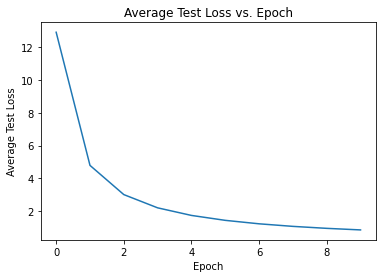

In [57]:
## Plot:
import matplotlib.pyplot as plt

plt.plot(range(0, len(test_losses)), test_losses)
plt.title("Average Test Loss vs. Epoch")
plt.ylabel("Average Test Loss")
plt.xlabel("Epoch")
plt.show()


### (d) (15 points) Report the final testing accuracy of trained model.

In [64]:
iters = 0 
correct = 0

for data in test_dataloader:
  # input = F.to_tensor(data["token_ids"], padding_value=padding_idx).to(device)
  target = torch.tensor(data["target"]).to(device).reshape(-1,1)
  # print(input.device)
  # print(target.device)

  # y_predict = model4(input)
  # _, pred = torch.max(y_predict, 1)
  y_predict = (torch.sign(model4(F.to_tensor(data['token_ids'], padding_value = padding_idx).to(device))-0.5)+1)/2
  iters += target.size(0)
  correct += (y_predict == target).sum().item()

accuracy = correct / iters
print(f"Test Accuracy is: ", accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:249: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Test Accuracy is:  0.981651376146789


Answer:

The final test accuracy of the trained model which we chose is approximately 0.9817.